# 预先生成图片



# Report 1: 偶尔可以train成功，看起来取决于数据特征
#### 已经保存在captcha-v1.h5中 

# Report 2: 第二次train成功
## 使用的是adadelta+可控数据，结果存在  captcha-v2.h5, train/val loss: 0.08/0.1, eval accu: 0.03!!
## fine tuning真实的数据，结果存在 captcha-v2-ft.h5 , loss分别是 0.22/0.26, eval accuracy: 0.91??
## output : gs://simple-ocr/captcha-v2-ft.h5 gs://simple-ocr/captcha-v2.h5

In [1]:
!pip install captcha
!pip install tqdm
!cat /proc/meminfo
# !kill -9 -1

    100% |████████████████████████████████| 112kB 2.1MB/s 
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 51kB 2.0MB/s 
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
MemTotal:       13335192 kB
MemFree:         1705080 kB
MemAvailable:   12031172 kB
Buffers:          147532 kB
Cached:         10115256 kB
SwapCached:            0 kB
Active:          1098864 kB
Inactive:        9833884 kB
Active(anon):     774176 kB
Inactive(anon):    84420 kB
Active(file):     324688 kB
Inactive(file):  9749464 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              2136 kB
Writeback:             0 kB
AnonPages:        670060 kB
Mapped:           226832 kB
Shmem:            254956 kB
Slab:  

In [2]:
!ls .

datalab


In [0]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import time
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
import os
import shutil
import traceback
import copy
import errno
import sys

In [0]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if  exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def to_id(file):
    return file.split(".")[0]

def to_labels(idx, ids):
    l = {}
    for id in ids:
        l[id] = idx
    return l

def get_ids(path):
    return [to_id(x) for x in os.listdir(path) if x.endswith(".png")]

def get_labels(path):
    classes = [x for x in os.listdir(path) if x.startswith("n")]
    all_ids = [get_ids(path + "/" + clz) for clz in classes]
    labels = {}
    [labels.update(to_labels(classes.index(clz), all_ids[classes.index(clz)])) for clz in classes]
    return (labels, classes)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5,1,u'5NHG')

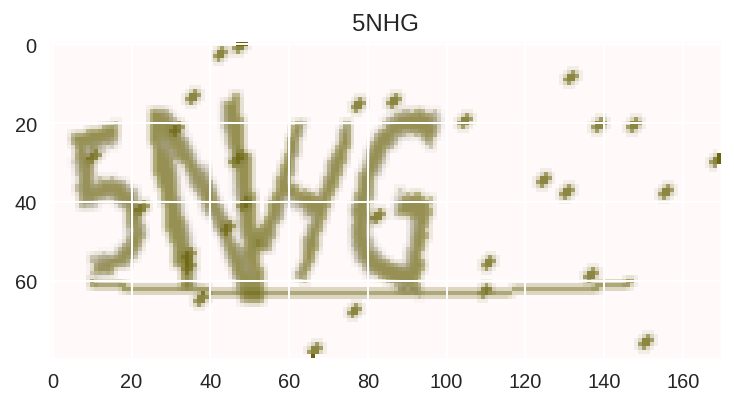

In [4]:
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)


In [0]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])


In [6]:
# generate data
start_time = time.time()
npy_file_count = 10
count_each_npy = 128
rootdir="./data/"
!rm -fr ${rootdir}
mkdir_p(rootdir)

print("start to generate, total count - " + str(npy_file_count * count_each_npy))
for t in range(0,npy_file_count):
   X, y = next(gen(count_each_npy))
   np.save(rootdir + str(t) + ".npy", [X, y])
  
elapsed_time = time.time() - start_time
print("generate done, total count - " + str(npy_file_count * count_each_npy) + ", time used " + str(elapsed_time) + "s")

start to generate, total count - 1280
generate done, total count - 1280, time used 4.53041696548s


In [7]:
# !ls -la ./data
[X,y] = np.load("./data/0.npy")
print(X.shape)
print(y[0].shape)
print((len(y)))

(128, 80, 170, 3)
(128, 36)
4


In [9]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

n_len = 4

def build_model():
  input_tensor = Input((height, width, 3))
  x = input_tensor
  
  for i in range(1):
#     x = Convolution2D(32*2**i, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
  
  x = Flatten()(x)
  x = Dense(n_class * 8, activation='relu', name='fc')(x)
  x = Dropout(0.25)(x)
  x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
  model = Model(input=input_tensor, output=x)

  model.compile(loss='categorical_crossentropy',
                optimizer = Adam(lr=0.1),
                metrics=['accuracy'])
  return model

def build_model_other():
  input_tensor = Input((height, width, 3))
  x = input_tensor
  for i in range(4):
      x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
      x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
      x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.25)(x)
  x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
  model = Model(input=input_tensor, output=x)

  model.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])
  return model

model = build_model_other()
model.summary()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/usr/local/lib

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 78, 168, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 76, 166, 32)  9248        conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 38, 83, 32)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


In [36]:
# generator
def batch_gen(batch_size = 16):
  batch_idx = 0
  while True:
      [X_all, y_all] = np.load(rootdir + str(batch_idx) + ".npy")
      for i in range(count_each_npy/batch_size):
          yield X_all[(i * batch_size):((i+1) * batch_size)], [y_all[j][(i * batch_size):((i+1) * batch_size)] for j in range(4)]
      batch_idx += 1
      batch_idx %= npy_file_count
 
X,y = next(batch_gen())
print(X.shape)
print(y[0].shape)
print(len(y))

(16, 80, 170, 3)
(16, 36)
4


In [11]:
!ls -l
# model.load_weights("./captcha-v1.h5")

total 8
drwxr-xr-x 2 root root 4096 Jul 23 01:24 data
drwxr-xr-x 3 root root 4096 Jul 19 16:53 datalab


In [39]:
from keras.callbacks import TensorBoard
batch_size = 16
tbCallBack = TensorBoard(log_dir='./log',
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)

model.fit_generator(batch_gen(batch_size), samples_per_epoch=1280, nb_epoch=5, 
                    nb_worker=2, pickle_safe=True, 
                    validation_data=batch_gen(batch_size), nb_val_samples=160,
                    callbacks=[tbCallBack])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., use_multiprocessing=True, workers=2, validation_data=<generator..., steps_per_epoch=1280, epochs=5, callbacks=[<keras.ca..., validation_steps=160)`
  if sys.path[0] == '':


Epoch 1/5
 452/1280 [=========>....................] - ETA: 1:00 - loss: 13.9026 - c1_loss: 3.4830 - c2_loss: 3.4714 - c3_loss: 3.4806 - c4_loss: 3.4676 - c1_acc: 0.0642 - c2_acc: 0.0672 - c3_acc: 0.0608 - c4_acc: 0.0632

 923/1280 [====================>.........] - ETA: 25s - loss: 12.8216 - c1_loss: 3.2704 - c2_loss: 3.1824 - c3_loss: 3.2134 - c4_loss: 3.1554 - c1_acc: 0.1264 - c2_acc: 0.1469 - c3_acc: 0.1377 - c4_acc: 0.1489

1280/1280 [==============================] - 95s 74ms/step - loss: 10.7019 - c1_loss: 2.8107 - c2_loss: 2.6247 - c3_loss: 2.6758 - c4_loss: 2.5907 - c1_acc: 0.2454 - c2_acc: 0.2895 - c3_acc: 0.2752 - c4_acc: 0.2940 - val_loss: 0.7034 - val_c1_loss: 0.2407 - val_c2_loss: 0.1566 - val_c3_loss: 0.1646 - val_c4_loss: 0.1414 - val_c1_acc: 0.9387 - val_c2_acc: 0.9570 - val_c3_acc: 0.9609 - val_c4_acc: 0.9602
Epoch 2/5
  36/1280 [..............................] - ETA: 1:25 - loss: 1.8154 - c1_loss: 0.5711 - c2_loss: 0.4698 - c3_loss: 0.4335 - c4_loss: 0.3409 - c1_acc: 0.8194 - c2_acc: 0.8663 - c3_acc: 0.8698 - c4_acc: 0.8854

 491/1280 [==========>...................] - ETA: 54s - loss: 0.9480 - c1_loss: 0.2890 - c2_loss: 0.2283 - c3_loss: 0.2248 - c4_loss: 0.2059 - c1_acc: 0.9133 - c2_acc: 0.9329 - c3_acc: 0.9322 - c4_acc: 0.9380

 952/1280 [=====================>........] - ETA: 22s - loss: 0.6855 - c1_loss: 0.2098 - c2_loss: 0.1565 - c3_loss: 0.1654 - c4_loss: 0.1538 - c1_acc: 0.9379 - c2_acc: 0.9538 - c3_acc: 0.9496 - c4_acc: 0.9547

1280/1280 [==============================] - 92s 72ms/step - loss: 0.5856 - c1_loss: 0.1788 - c2_loss: 0.1341 - c3_loss: 0.1424 - c4_loss: 0.1303 - c1_acc: 0.9469 - c2_acc: 0.9608 - c3_acc: 0.9569 - c4_acc: 0.9617 - val_loss: 0.0089 - val_c1_loss: 0.0031 - val_c2_loss: 0.0015 - val_c3_loss: 0.0014 - val_c4_loss: 0.0029 - val_c1_acc: 0.9996 - val_c2_acc: 1.0000 - val_c3_acc: 1.0000 - val_c4_acc: 1.0000
Epoch 3/5
  49/1280 [>.............................] - ETA: 1:26 - loss: 0.2557 - c1_loss: 0.0530 - c2_loss: 0.0808 - c3_loss: 0.0451 - c4_loss: 0.0767 - c1_acc: 0.9885 - c2_acc: 0.9796 - c3_acc: 0.9847 - c4_acc: 0.9821

 518/1280 [===========>..................] - ETA: 53s - loss: 0.2213 - c1_loss: 0.0698 - c2_loss: 0.0411 - c3_loss: 0.0538 - c4_loss: 0.0567 - c1_acc: 0.9812 - c2_acc: 0.9873 - c3_acc: 0.9838 - c4_acc: 0.9855

 995/1280 [======================>.......] - ETA: 19s - loss: 0.2103 - c1_loss: 0.0669 - c2_loss: 0.0417 - c3_loss: 0.0490 - c4_loss: 0.0527 - c1_acc: 0.9823 - c2_acc: 0.9872 - c3_acc: 0.9851 - c4_acc: 0.9864

1280/1280 [==============================] - 93s 73ms/step - loss: 0.1959 - c1_loss: 0.0605 - c2_loss: 0.0397 - c3_loss: 0.0465 - c4_loss: 0.0493 - c1_acc: 0.9843 - c2_acc: 0.9880 - c3_acc: 0.9857 - c4_acc: 0.9869 - val_loss: 0.0022 - val_c1_loss: 1.7688e-04 - val_c2_loss: 9.8627e-05 - val_c3_loss: 0.0017 - val_c4_loss: 2.3891e-04 - val_c1_acc: 1.0000 - val_c2_acc: 1.0000 - val_c3_acc: 0.9992 - val_c4_acc: 1.0000
Epoch 4/5
  60/1280 [>.............................] - ETA: 1:24 - loss: 0.1340 - c1_loss: 0.0393 - c2_loss: 0.0250 - c3_loss: 0.0496 - c4_loss: 0.0202 - c1_acc: 0.9896 - c2_acc: 0.9927 - c3_acc: 0.9885 - c4_acc: 0.9938

 527/1280 [===========>..................] - ETA: 53s - loss: 0.1480 - c1_loss: 0.0418 - c2_loss: 0.0316 - c3_loss: 0.0402 - c4_loss: 0.0344 - c1_acc: 0.9881 - c2_acc: 0.9917 - c3_acc: 0.9872 - c4_acc: 0.9899

1000/1280 [======================>.......] - ETA: 19s - loss: 0.1305 - c1_loss: 0.0384 - c2_loss: 0.0296 - c3_loss: 0.0316 - c4_loss: 0.0309 - c1_acc: 0.9889 - c2_acc: 0.9919 - c3_acc: 0.9906 - c4_acc: 0.9912

1280/1280 [==============================] - 93s 73ms/step - loss: 0.1282 - c1_loss: 0.0384 - c2_loss: 0.0291 - c3_loss: 0.0302 - c4_loss: 0.0305 - c1_acc: 0.9892 - c2_acc: 0.9922 - c3_acc: 0.9912 - c4_acc: 0.9912 - val_loss: 5.9722e-04 - val_c1_loss: 1.1437e-04 - val_c2_loss: 6.5549e-05 - val_c3_loss: 6.2000e-05 - val_c4_loss: 3.5530e-04 - val_c1_acc: 1.0000 - val_c2_acc: 1.0000 - val_c3_acc: 1.0000 - val_c4_acc: 1.0000
Epoch 5/5
  63/1280 [>.............................] - ETA: 1:23 - loss: 0.0800 - c1_loss: 0.0356 - c2_loss: 0.0117 - c3_loss: 0.0209 - c4_loss: 0.0119 - c1_acc: 0.9901 - c2_acc: 0.9950 - c3_acc: 0.9931 - c4_acc: 0.9960

 535/1280 [===========>..................] - ETA: 51s - loss: 0.1107 - c1_loss: 0.0332 - c2_loss: 0.0282 - c3_loss: 0.0281 - c4_loss: 0.0212 - c1_acc: 0.9909 - c2_acc: 0.9925 - c3_acc: 0.9924 - c4_acc: 0.9944

1010/1280 [======================>.......] - ETA: 18s - loss: 0.1013 - c1_loss: 0.0334 - c2_loss: 0.0248 - c3_loss: 0.0227 - c4_loss: 0.0204 - c1_acc: 0.9910 - c2_acc: 0.9931 - c3_acc: 0.9934 - c4_acc: 0.9946

1280/1280 [==============================] - 93s 72ms/step - loss: 0.0964 - c1_loss: 0.0294 - c2_loss: 0.0232 - c3_loss: 0.0222 - c4_loss: 0.0216 - c1_acc: 0.9919 - c2_acc: 0.9937 - c3_acc: 0.9938 - c4_acc: 0.9941 - val_loss: 1.5273e-04 - val_c1_loss: 3.6702e-05 - val_c2_loss: 6.3371e-05 - val_c3_loss: 3.3053e-05 - val_c4_loss: 1.9599e-05 - val_c1_acc: 1.0000 - val_c2_acc: 1.0000 - val_c3_acc: 1.0000 - val_c4_acc: 1.0000


In [0]:
# model.save_weights("captcha-v2.h5")
model.load_weights("captcha-v2.h5")

In [58]:
# train by online
model.fit_generator(gen(), samples_per_epoch=1280, nb_epoch=5, 
                    nb_worker=2, pickle_safe=True, 
                    validation_data=gen(), nb_val_samples=160, callbacks=[tbCallBack])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., use_multiprocessing=True, workers=2, validation_data=<generator..., steps_per_epoch=1280, epochs=5, callbacks=[<keras.ca..., validation_steps=160)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
 456/1280 [=========>....................] - ETA: 1:36 - loss: 5.6528 - c1_loss: 2.0785 - c2_loss: 1.1422 - c3_loss: 1.3402 - c4_loss: 1.0918 - c1_acc: 0.3929 - c2_acc: 0.6501 - c3_acc: 0.6000 - c4_acc: 0.6704

 934/1280 [====================>.........] - ETA: 39s - loss: 3.6585 - c1_loss: 1.3288 - c2_loss: 0.7211 - c3_loss: 0.8907 - c4_loss: 0.7179 - c1_acc: 0.5995 - c2_acc: 0.7748 - c3_acc: 0.7316 - c4_acc: 0.7814

1280/1280 [==============================] - 161s 126ms/step - loss: 2.9369 - c1_loss: 1.0410 - c2_loss: 0.5775 - c3_loss: 0.7309 - c4_loss: 0.5875 - c1_acc: 0.6841 - c2_acc: 0.8186 - c3_acc: 0.7792 - c4_acc: 0.8209 - val_loss: 0.5521 - val_c1_loss: 0.1419 - val_c2_loss: 0.0956 - val_c3_loss: 0.1776 - val_c4_loss: 0.1370 - val_c1_acc: 0.9504 - val_c2_acc: 0.9639 - val_c3_acc: 0.9414 - val_c4_acc: 0.9539
Epoch 2/5
  44/1280 [>.............................] - ETA: 2:29 - loss: 0.8418 - c1_loss: 0.2109 - c2_loss: 0.1701 - c3_loss: 0.2480 - c4_loss: 0.2128 - c1_acc: 0.9290 - c2_acc: 0.9389 - c3_acc: 0.9261 - c4_acc: 0.9396

 521/1280 [===========>..................] - ETA: 1:28 - loss: 0.7038 - c1_loss: 0.1699 - c2_loss: 0.1441 - c3_loss: 0.2167 - c4_loss: 0.1732 - c1_acc: 0.9446 - c2_acc: 0.9485 - c3_acc: 0.9323 - c4_acc: 0.9459

 999/1280 [======================>.......] - ETA: 32s - loss: 0.6346 - c1_loss: 0.1491 - c2_loss: 0.1259 - c3_loss: 0.2029 - c4_loss: 0.1567 - c1_acc: 0.9495 - c2_acc: 0.9559 - c3_acc: 0.9356 - c4_acc: 0.9508

1280/1280 [==============================] - 159s 124ms/step - loss: 0.5995 - c1_loss: 0.1408 - c2_loss: 0.1169 - c3_loss: 0.1919 - c4_loss: 0.1499 - c1_acc: 0.9523 - c2_acc: 0.9592 - c3_acc: 0.9390 - c4_acc: 0.9528 - val_loss: 0.3087 - val_c1_loss: 0.0613 - val_c2_loss: 0.0663 - val_c3_loss: 0.1069 - val_c4_loss: 0.0742 - val_c1_acc: 0.9770 - val_c2_acc: 0.9750 - val_c3_acc: 0.9668 - val_c4_acc: 0.9730
Epoch 3/5
  65/1280 [>.............................] - ETA: 2:17 - loss: 0.4196 - c1_loss: 0.0913 - c2_loss: 0.0979 - c3_loss: 0.1373 - c4_loss: 0.0931 - c1_acc: 0.9668 - c2_acc: 0.9654 - c3_acc: 0.9524 - c4_acc: 0.9707

 542/1280 [===========>..................] - ETA: 1:23 - loss: 0.4315 - c1_loss: 0.0941 - c2_loss: 0.0848 - c3_loss: 0.1456 - c4_loss: 0.1070 - c1_acc: 0.9685 - c2_acc: 0.9697 - c3_acc: 0.9536 - c4_acc: 0.9651

1020/1280 [======================>.......] - ETA: 29s - loss: 0.4058 - c1_loss: 0.0866 - c2_loss: 0.0797 - c3_loss: 0.1380 - c4_loss: 0.1015 - c1_acc: 0.9710 - c2_acc: 0.9713 - c3_acc: 0.9556 - c4_acc: 0.9665

1280/1280 [==============================] - 157s 123ms/step - loss: 0.3915 - c1_loss: 0.0847 - c2_loss: 0.0778 - c3_loss: 0.1311 - c4_loss: 0.0979 - c1_acc: 0.9714 - c2_acc: 0.9717 - c3_acc: 0.9573 - c4_acc: 0.9676 - val_loss: 0.3320 - val_c1_loss: 0.0663 - val_c2_loss: 0.0741 - val_c3_loss: 0.1176 - val_c4_loss: 0.0741 - val_c1_acc: 0.9789 - val_c2_acc: 0.9721 - val_c3_acc: 0.9611 - val_c4_acc: 0.9727
Epoch 4/5
  72/1280 [>.............................] - ETA: 2:18 - loss: 0.3195 - c1_loss: 0.0670 - c2_loss: 0.0617 - c3_loss: 0.1005 - c4_loss: 0.0903 - c1_acc: 0.9787 - c2_acc: 0.9783 - c3_acc: 0.9688 - c4_acc: 0.9701

 549/1280 [===========>..................] - ETA: 1:22 - loss: 0.3308 - c1_loss: 0.0709 - c2_loss: 0.0684 - c3_loss: 0.1040 - c4_loss: 0.0875 - c1_acc: 0.9742 - c2_acc: 0.9748 - c3_acc: 0.9668 - c4_acc: 0.9709

1027/1280 [=======================>......] - ETA: 28s - loss: 0.3134 - c1_loss: 0.0676 - c2_loss: 0.0635 - c3_loss: 0.1006 - c4_loss: 0.0817 - c1_acc: 0.9759 - c2_acc: 0.9771 - c3_acc: 0.9676 - c4_acc: 0.9725

1280/1280 [==============================] - 159s 125ms/step - loss: 0.3063 - c1_loss: 0.0681 - c2_loss: 0.0617 - c3_loss: 0.0973 - c4_loss: 0.0792 - c1_acc: 0.9758 - c2_acc: 0.9777 - c3_acc: 0.9681 - c4_acc: 0.9734 - val_loss: 0.1880 - val_c1_loss: 0.0430 - val_c2_loss: 0.0315 - val_c3_loss: 0.0675 - val_c4_loss: 0.0460 - val_c1_acc: 0.9816 - val_c2_acc: 0.9879 - val_c3_acc: 0.9771 - val_c4_acc: 0.9857
Epoch 5/5
  75/1280 [>.............................] - ETA: 2:17 - loss: 0.2534 - c1_loss: 0.0531 - c2_loss: 0.0473 - c3_loss: 0.0783 - c4_loss: 0.0746 - c1_acc: 0.9796 - c2_acc: 0.9829 - c3_acc: 0.9704 - c4_acc: 0.9762

 552/1280 [===========>..................] - ETA: 1:22 - loss: 0.2726 - c1_loss: 0.0547 - c2_loss: 0.0585 - c3_loss: 0.0892 - c4_loss: 0.0702 - c1_acc: 0.9793 - c2_acc: 0.9787 - c3_acc: 0.9688 - c4_acc: 0.9757

1030/1280 [=======================>......] - ETA: 28s - loss: 0.2636 - c1_loss: 0.0541 - c2_loss: 0.0573 - c3_loss: 0.0825 - c4_loss: 0.0697 - c1_acc: 0.9799 - c2_acc: 0.9789 - c3_acc: 0.9708 - c4_acc: 0.9757

1280/1280 [==============================] - 157s 123ms/step - loss: 0.2590 - c1_loss: 0.0542 - c2_loss: 0.0556 - c3_loss: 0.0811 - c4_loss: 0.0681 - c1_acc: 0.9800 - c2_acc: 0.9795 - c3_acc: 0.9718 - c4_acc: 0.9761 - val_loss: 0.1698 - val_c1_loss: 0.0368 - val_c2_loss: 0.0349 - val_c3_loss: 0.0581 - val_c4_loss: 0.0400 - val_c1_acc: 0.9873 - val_c2_acc: 0.9867 - val_c3_acc: 0.9811 - val_c4_acc: 0.9836


In [0]:
model.save_weights("captcha-v2-ft.h5")
# model.load_weights("captcha-v2.h5")


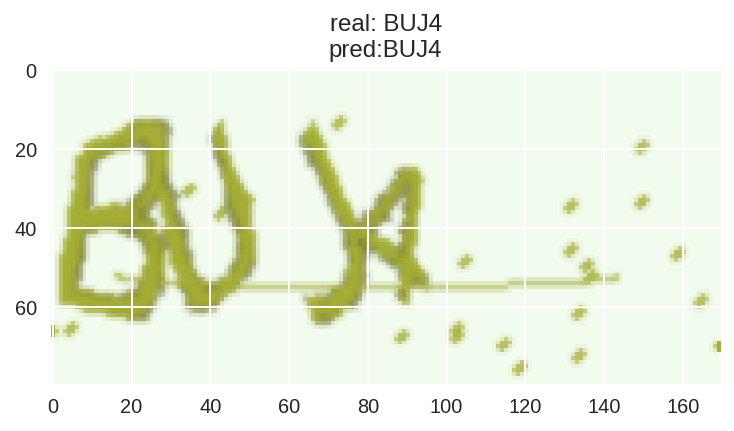

In [60]:
# 手动测试模型
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')

In [61]:
from tqdm import tqdm
def evaluate(model, batch_num=32):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        batch_acc += np.mean(map(np.array_equal, y_true, y_pred))
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 32/32 [00:04<00:00,  7.61it/s]


0.9365234375

In [0]:
from google.colab import auth
auth.authenticate_user()
project_id = 'complete-treat-176910'


In [65]:
!gcloud config set project {project_id}
bucket_name="sample-ocr"

Updated property [core/project].


In [68]:
!gsutil cp captcha-v2-ft.h5 gs://simple-ocr/captcha-v2-ft.h5

Copying file://captcha-v2-ft.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/5.4 MiB.                                      
